# Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the cast study of applying seq2seq model for time series data. 

The purpose is to showcase the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into four parts - first we will be demonstrating how to train a basicseq2seq model on univariate data. The model is then easily applied to multivariate cases. We will then discuss about situation with outliers. And finally, we will showcase a real-world dataset to forecast pollution (pm2.5) in Beijing. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

This is a long notebook - you can choose the session of your interests by clicking on the links below: 

## Contents

### 1) <b>[Univariate time series](#session1)</b> 

### 2) <b>[Multivariate time series](#session2)</b> 

### 3) <b>[Seq2seq for outliers/extreme events](#session3)</b> 

### 4) <b>[A case study - Beijing pollution data](#session4)</b> 
data credits go to UCI - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

<a id='session1'></a>
# Univariate time series

In [1]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy


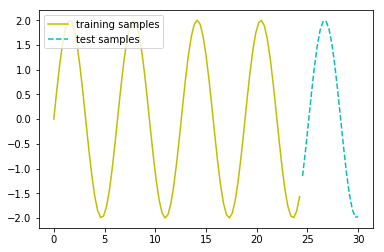

In [2]:
x = np.linspace(0, 30, 105)
y = 2 * np.sin(x)

l1, = plt.plot(x[:85], y[:85], 'y', label = 'training samples')
l2, = plt.plot(x[85:], y[85:105], 'c--', label = 'test samples')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

<a id='Session2'></a>
## Real-world training data may be noisier

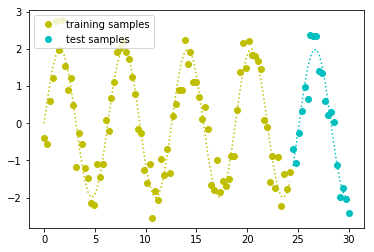

In [3]:
train_y = y.copy()

noise_factor = 0.5
train_y += np.random.randn(105) * noise_factor

l1, = plt.plot(x[:85], train_y[:85], 'yo', label = 'training samples')
plt.plot(x[:85], y[:85], 'y:')
l2, = plt.plot(x[85:], train_y[85:], 'co', label = 'test samples')
plt.plot(x[85:], y[85:], 'c:')
plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

## Create function for generating training samples

In [4]:
input_seq_len = 15
output_seq_len = 20

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x):
    return true_signal(x) + noise_func(x)

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    '''
    returns:
        np.array(input_seq_y) shape : [batch_size, input_seq_len]
        np.array(output_seq_y) shape : [batch_size, output_seq_len]
    '''
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x) for x in input_seq_x]
    output_seq_y = [generate_y_values(x) for x in output_seq_x]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y)


In [5]:
input_seq, output_seq = generate_train_samples(batch_size=10)

In [6]:
input_seq.shape, output_seq.shape

((10, 15), (10, 20))

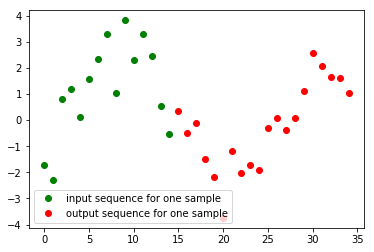

In [7]:
l1, = plt.plot(range(15), input_seq[1], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[1], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

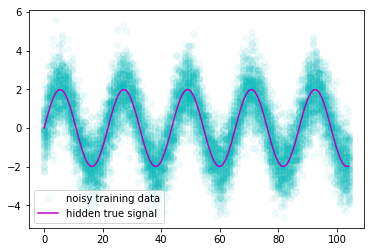

In [8]:
results = []
for i in range(100):
    temp = generate_y_values(x)
    results.append(temp)
results = np.array(results)

for i in range(100):
    l1, = plt.plot(results[i].reshape(105, -1), 'co', lw = 0.1, alpha = 0.05, label = 'noisy training data')

l2, = plt.plot(true_signal(x), 'm', label = 'hidden true signal')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## basic_rnn_seq2seq

In [9]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

## Training process

In [10]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 30, 105)
train_data_x = x[:85]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

54.8855
43.8557
34.3539
32.1838
27.9283
27.6266
27.8152
24.412
24.8899
26.1346
21.9077
21.6697
24.564
25.3063
21.3617
25.1922
25.3175
20.2574
21.2237
26.093
19.3096
23.2545
26.2421
23.7648
24.2661
24.2486
25.6494
27.8852
23.3551
22.3391
22.0037
26.7024
24.164
23.8742
23.652
24.9503
21.3352
25.8553
22.0426
25.2508
20.6976
24.007
25.3094
22.9837
23.3247
24.211
21.838
19.828
26.5159
20.4721
25.0679
23.0827
24.3862
23.9051
19.9451
20.7908
21.3127
21.9598
19.676
24.0273
22.7083
22.6578
23.3854
22.9711
24.3393
24.1876
21.9389
21.5637
23.5147
20.7754
20.0367
26.7387
22.4683
20.5031
24.0989
23.0563
22.5581
19.7226
25.1218
21.112
21.6142
20.9573
22.15
19.7292
25.7982
20.9163
24.6404
25.6658
20.4054
20.8786
25.9638
21.7444
20.9383
22.7654
24.9887
23.1897
24.3309
23.0556
20.3155
21.814
Checkpoint saved at:  ./univariate_ts_model0


## Inference

In [11]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


## Plot the last 20 predictions

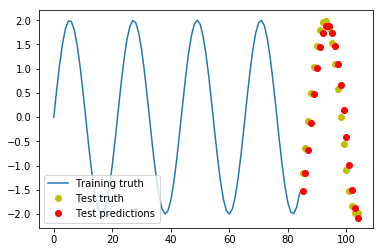

In [12]:
l1, = plt.plot(range(85), true_signal(train_data_x[:85]), label = 'Training truth')
l2, = plt.plot(range(85, 105), y[85:], 'yo', label = 'Test truth')
l3, = plt.plot(range(85, 105), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l1, l2, l3], loc = 'lower left')
plt.show()

<a id='session2'></a>
# Multivariate time series: 


### Input sequences

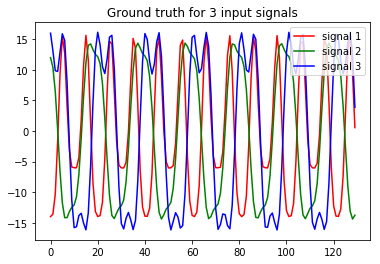

In [13]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2*x1 + 6*x2 - 6*x1
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Ground truth for 3 input signals")
l1, = plt.plot(y1, 'r', label = 'signal 1')
l2, = plt.plot(y2, 'g', label = 'signal 2')
l3, = plt.plot(y3, 'b', label = 'signal 3')

plt.legend(handles = [l1, l2, l3], loc = 'upper right')

plt.show()

### Both input and output sequences

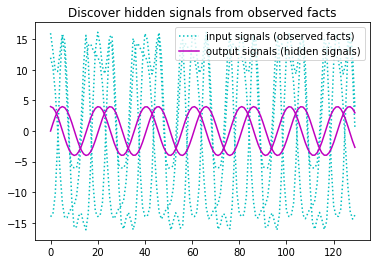

In [274]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = 1.6*x1**4 - 2*x2 - 10
y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
y3 = 2*x1**3 + 2*x2**3 - x1*x2

plt.title("Discover hidden signals from observed facts")
l1, = plt.plot(y1, 'c:', label = 'input signals (observed facts)')
plt.plot(y2, 'c:')
plt.plot(y3, 'c:')

l4, = plt.plot(2 * x1, 'm', label = 'output signals (hidden signals)')
plt.plot(2 * x2, 'm') # multiplies by 2 just for visualization purpose

plt.legend(handles = [l1, l4], loc = 'upper right')

plt.show()

## Create function that generates training samples

In [275]:
input_seq_len = 15
output_seq_len = 20
x = np.linspace(0, 40, 130)
train_data_x = x[:110]

def true_output_signals(x):
    x1 = 2 * np.sin(x)
    x2 = 2 * np.cos(x)
    return x1, x2

def true_input_signals(x):
    x1, x2 = true_output_signals(x)
    y1 = 1.6*x1**4 - 2*x2 - 10
    y2 = 1.2*x2**2 * x1 + 2*x2*3 - x1*6
    y3 = 2*x1**3 + 2*x2**3 - x1*x2
    return y1, y2, y3

def noise_func(x, noise_factor = 2):
    return np.random.randn(len(x)) * noise_factor

def generate_samples_for_output(x):
    x1, x2 = true_output_signals(x)
    return x1+noise_func(x1, 0.5), \
           x2+noise_func(x2, 0.5)

def generate_samples_for_input(x):
    y1, y2, y3 = true_input_signals(x)
    return y1+noise_func(y1, 2), \
           y2+noise_func(y2, 2), \
           y3+noise_func(y3, 2)

def generate_train_samples(x = train_data_x, batch_size = 10):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_samples_for_input(x) for x in input_seq_x]
    output_seq_y = [generate_samples_for_output(x) for x in output_seq_x]
    
    ## return shape: (batch_size, time_steps, feature_dims)
    return np.array(input_seq_y).transpose(0, 2, 1), np.array(output_seq_y).transpose(0, 2, 1)


### Visualize one data sample from training

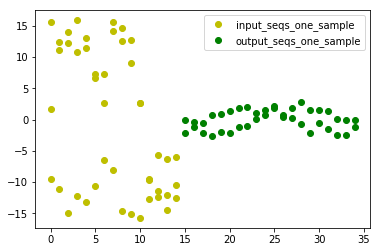

In [276]:
input_seq, output_seq = generate_train_samples(batch_size=100)

i1, i2, i3= plt.plot(range(input_seq_len), input_seq[0], 'yo', label = 'input_seqs_one_sample')
o1, o2 = plt.plot(range(input_seq_len,(input_seq_len+output_seq_len)), output_seq[0], 'go', label = 'output_seqs_one_sample')
plt.legend(handles = [i1, o1])
plt.show()



## Build the model

In [277]:
from build_model_multi_variate import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 3 
# num of output signals
output_dim = 2 
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

## Train the model

In [278]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
64.2128
28.6208
25.0749
25.0917
15.6719
10.339
10.1405
8.78899
7.40599
7.2843
7.17353
6.95969
7.00498
6.83154
6.08503
6.05086
7.04767
5.94551
6.24737
6.02971
6.28249
6.13069
6.50115
6.0175
5.52102
5.81162
5.65957
6.00738
5.91883
5.94311
5.57701
5.71498
5.79946
5.69771
6.64276
6.03791
5.22044
5.69816
5.96274
5.70673
5.29704
5.75264
5.35655
6.36531
5.88117
5.413
5.11999
5.61508
5.47116
6.1913
6.21914
5.6628
5.43533
6.43791
5.61307
6.06029
5.42362
6.00235
5.93072
5.51793
6.30841
5.38553
5.61262
6.00262
5.52363
5.93103
5.69512
5.32481
6.054
5.65259
5.59224
5.23299
5.41849
5.96831
5.89101
5.91692
5.92938
5.71318
6.03872
5.76452
6.04928
5.61834
5.58975
5.703
5.61251
5.44963
5.26935
6.6134
6.0066
5.90343
5.2958
5.4402
5.62414
5.47787
6.48795
5.68854
6.0335
5.65404
5.30624
5.26605
Checkpoint saved at:  ./multivariate_ts_model0


## Inference

In [280]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1, -1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 0)
    

INFO:tensorflow:Restoring parameters from ./multivariate_ts_model0


## Visualize predictions over true signals 

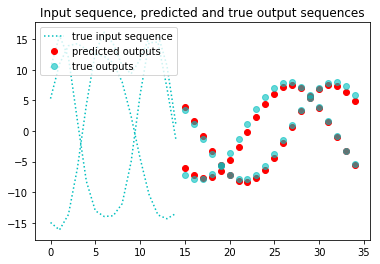

In [281]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Input sequence, predicted and true output sequences")
i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), 4 * final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), 4 * np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', alpha = 0.6, label = 'true outputs')
plt.legend(handles = [i1, p1, t1], loc = 'upper left')
plt.show()


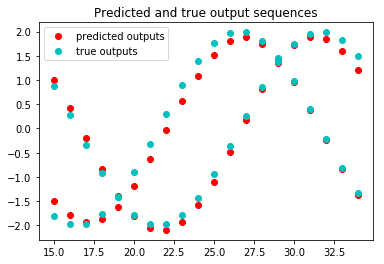

In [282]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
plt.title("Predicted and true output sequences")
#i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), np.array(true_output_signals(x[110:])).transpose(1, 0), 'co', label = 'true outputs')
plt.legend(handles = [p1, t1], loc = 'upper left')
plt.show()

<a id='session3'></a>
# Extreme events / outliers

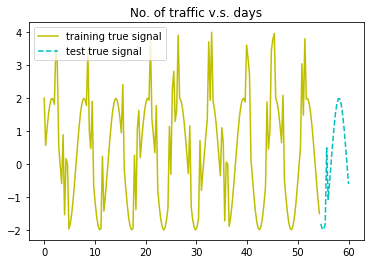

In [283]:
x = np.linspace(0, 60, 210)
y = 2 * np.sin(x)
num_events_train = 40
num_events_test = 1
extreme_factor = 2
np.random.seed(10)
train_events_x = np.random.choice(range(190), num_events_train)
test_events_x = np.random.choice(range(190, 210), num_events_test)
y[train_events_x] += extreme_factor
y[test_events_x] += extreme_factor

plt.title('No. of traffic v.s. days')

l1, = plt.plot(x[:190], y[:190], 'y', label = 'training true signal')
l2, = plt.plot(x[190:], y[190:], 'c--', label = 'test true signal')

plt.legend(handles = [l1, l2], loc = 'upper left')
plt.show()

In [284]:
input_seq_len = 15
output_seq_len = 20
extreme_factor = 2 # additional units of traffic increase if extreme / outlier

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

np.random.seed(10)
num_events_train = 40 # total number of extreme events in training data
train_events_bool = np.zeros(190)
train_events_x = np.random.choice(range(190), num_events_train)
train_events_bool[train_events_x] = 1

num_events_test = 1 # total number of extreme events in test data 
test_events_bool = np.zeros(20)
test_events_x = np.random.choice(range(20), num_events_test)
test_events_bool[test_events_x] = 1.
                    
def true_signal(x):
    y = 2 * np.sin(x)
    return y

def noise_func(x, noise_factor = 1):
    return np.random.randn(len(x)) * noise_factor

def generate_y_values(x, event_bool):
    return true_signal(x) + noise_func(x) + extreme_factor * event_bool

def generate_train_samples(x = train_data_x, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len, train_events_bool = train_events_bool):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    input_seq_event_bool = [train_events_bool[i:(i+input_seq_len)] for i in start_x_idx]
    
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    output_seq_event_bool = [train_events_bool[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(input_seq_x, input_seq_event_bool)]
    output_seq_y = [generate_y_values(x, event_bool) for x, event_bool in zip(output_seq_x, output_seq_event_bool)]
    
    #batch_x = np.array([[true_signal()]])
    return np.array(input_seq_y), np.array(output_seq_y), np.array(input_seq_event_bool), np.array(output_seq_event_bool)

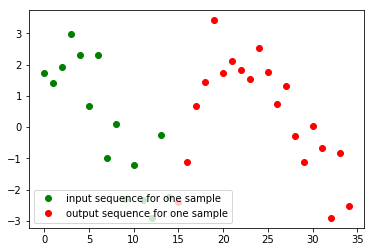

In [285]:
input_seq, output_seq, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=10)
l1, = plt.plot(range(15), input_seq[0], 'go', label = 'input sequence for one sample')
l2, = plt.plot(range(15, 35), output_seq[0], 'ro', label = 'output sequence for one sample')
plt.legend(handles = [l1, l2], loc = 'lower left')
plt.show()

## 1) Using the basic univariate model

In [289]:
from build_model_basic import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 


In [290]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, input_seq_event_bool, output_seq_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)

75.9673
59.9178
62.3818
65.5012
39.3826
36.5686
52.1571
45.0297
34.0152
36.0494
39.1921
36.6797
37.0878
36.7641
44.967
42.7421
40.5694
36.0216
41.907
38.5079
35.8162
35.2155
38.3369
32.7804
34.2715
37.9601
32.4221
38.1209
46.0107
32.4662
32.196
35.2335
37.3758
32.8057
33.8418
35.9087
35.6621
34.9327
37.6118
35.3103
31.3977
31.3586
31.97
32.4089
37.1042
31.6982
37.67
31.5908
36.4522
33.9084
34.6225
36.5167
33.8644
32.8995
32.9544
43.555
35.5108
33.2013
34.95
38.1578
41.3422
38.3371
31.7813
32.4616
33.7675
35.0416
36.8338
35.3056
39.3382
37.8452
36.8348
36.9547
35.3714
37.1198
42.2006
33.3306
36.7649
31.6731
34.6078
37.4059
35.9485
33.8689
33.2824
33.5961
32.1088
35.7565
34.7533
35.5384
31.573
33.8337
32.3139
34.7651
34.1048
36.2784
33.3462
34.5726
31.7294
34.8327
35.8149
33.6991
32.3435
33.6966
33.8734
31.8509
37.627
33.2913
32.4297
35.8865
34.5952
29.1155
35.5164
37.564
34.8258
34.4597
31.174
34.7577
36.0713
31.8826
28.0637
39.5275
32.1046
36.2919
30.5978
35.2627
35.6331
35.1498
34.984

## Inference

In [292]:
test_seq_input = true_signal(train_data_x[-15:])

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim]) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 1)

INFO:tensorflow:Restoring parameters from ./univariate_ts_model0


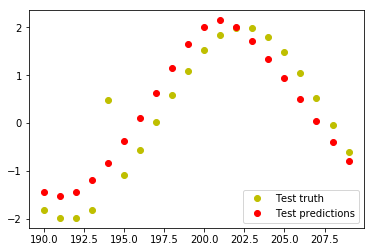

In [293]:
#l1, = plt.plot(range(190), true_signal(train_data_x[:190]), label = 'Training truth')
l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

## 2) Using seq2seq with extreme events input to decoder

In [308]:
from build_model_with_outliers import * 

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = 1
# num of output signals
output_dim = 1
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

In [309]:
total_iteractions = 200
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 60, 210)
train_data_x = x[:190]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    for i in range(total_iteractions):
        batch_input, batch_output, batch_in_event_bool, batch_out_event_bool = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t].reshape(-1,input_dim) for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t].reshape(-1,output_dim) for t in range(output_seq_len)})
        #feed_dict.update({rnn_model['input_seq_extremes_bool'][t]: batch_in_event_bool[:,t].reshape(-1,1) for t in range(input_seq_len)})
        feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: batch_out_event_bool[:,t].reshape(-1,1) for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'univariate_ts_model_eventsBool'))
        
print("Checkpoint saved at: ", save_path)

78.8276
66.8042
51.6649
67.0797
41.9553
56.1113
47.4071
33.3434
41.6836
45.5661
39.7866
36.2997
39.4818
37.0617
40.7857
39.5524
37.0894
38.4574
32.122
35.256
38.6262
33.3138
37.3801
33.0894
38.1154
37.3743
32.342
36.9055
31.2909
33.8738
33.4793
32.2983
36.9979
39.0167
36.3832
32.5085
32.487
31.2458
34.9322
38.4524
29.8378
32.6063
29.7634
38.6511
32.4908
34.3639
36.144
33.8463
33.8423
32.6575
27.791
33.3984
34.1619
28.8376
33.3242
33.8179
30.7528
31.0163
34.9156
29.6787
38.2492
37.2946
32.476
29.0392
29.7978
32.5308
36.8824
28.8405
31.0703
30.5008
30.6409
27.6839
30.3481
32.0772
36.5268
31.1707
26.9489
32.4432
27.8832
26.4437
28.9944
27.9709
29.1564
29.7332
28.1853
28.3643
25.9979
29.0084
25.7884
21.8616
29.6087
29.3637
26.4809
24.5202
23.5947
26.5767
25.7621
24.0534
22.5964
25.1564
19.7556
22.3542
22.2953
24.5599
22.8954
24.5486
24.0907
24.5875
26.2629
25.4185
22.5687
23.5025
22.8976
23.1173
26.4146
22.1425
22.9116
24.8657
22.4877
20.2016
22.2127
23.0341
24.4987
20.3284
26.0886
22.8221

## Inference

In [310]:
test_seq_input = true_signal(train_data_x[-15:])
test_events_bool_input = train_events_bool[-15:]
test_events_bool_output = test_events_bool.copy()

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'univariate_ts_model_eventsBool'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1,1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, 1]) for t in range(output_seq_len)})
    feed_dict.update({rnn_model['output_seq_extremes_bool'][t]: test_events_bool_output[t].reshape(1,1) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    

INFO:tensorflow:Restoring parameters from ./univariate_ts_model_eventsBool


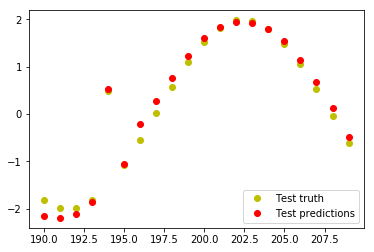

In [311]:
final_preds  = np.array(final_preds).reshape(-1)

l2, = plt.plot(range(190, 210), y[190:], 'yo', label = 'Test truth')
l3, = plt.plot(range(190, 210), final_preds.reshape(-1), 'ro', label = 'Test predictions')
plt.legend(handles = [l2, l3], loc = 'lower right')
plt.show()

<a id='session4'></a>
# Real-world case - Beijing PM2.5 Data Set

This data set can be downloaded from UCI website - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

The remaining session will use this dataset as an example to demonstrate on how to apply seq2seq model to solve a real world problem



## Data exploration

   No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES cbwd    Iws  Is  Ir
0   1  2010      1    1     0    NaN   -21 -11.0  1021.0   NW   1.79   0   0
1   2  2010      1    1     1    NaN   -21 -12.0  1020.0   NW   4.92   0   0
2   3  2010      1    1     2    NaN   -21 -11.0  1019.0   NW   6.71   0   0
3   4  2010      1    1     3    NaN   -21 -14.0  1019.0   NW   9.84   0   0
4   5  2010      1    1     4    NaN   -20 -12.0  1018.0   NW  12.97   0   0


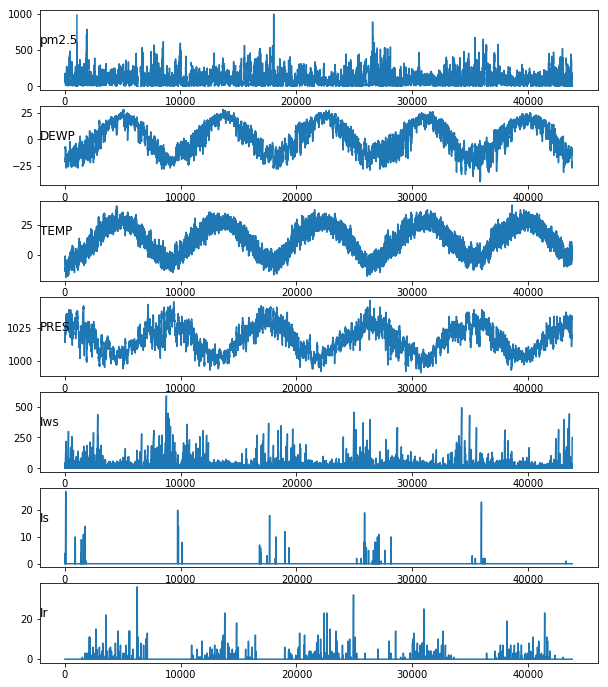

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns

df = pd.read_csv('./PRSA_data_2010.1.1-2014.12.31.csv')
print(df.head())

cols_to_plot = ["pm2.5", "DEWP", "TEMP", "PRES", "Iws", "Is", "Ir"]
i = 1
# plot each column
plt.figure(figsize = (10,12))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(df[col])
    plt.title(col, y=0.5, loc='left')
    i += 1
plt.show()

## Preprocessing - there are many other ways

In [2]:
## Fill NA with 0 
#print(df.isnull().sum())
df.fillna(0, inplace = True)

## One-hot encode 'cbwd'
temp = pd.get_dummies(df['cbwd'], prefix='cbwd')
df = pd.concat([df, temp], axis = 1)
del df['cbwd'], temp

## Split into train and test - I used the last 1 month data as test, but it's up to you to decide the ratio
df_train = df.iloc[:(-31*24), :].copy()
df_test = df.iloc[-31*24:, :].copy()

## take out the useful columns for modeling - you may also keep 'hour', 'day' or 'month' and to see if that will improve your accuracy
X_train = df_train.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
X_test = df_test.loc[:, ['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NE', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']].values.copy()
y_train = df_train['pm2.5'].values.copy().reshape(-1, 1)
y_test = df_test['pm2.5'].values.copy().reshape(-1, 1)

## z-score transform x - not including those one-how columns!
for i in range(X_train.shape[1]-4):
    temp_mean = X_train[:, i].mean()
    temp_std = X_train[:, i].std()
    X_train[:, i] = (X_train[:, i] - temp_mean) / temp_std
    X_test[:, i] = (X_test[:, i] - temp_mean) / temp_std
    
## z-score transform y
y_mean = y_train.mean()
y_std = y_train.std()
y_train = (y_train - y_mean) / y_std
y_test = (y_test - y_mean) / y_std

## Prepare training and test datasets in 3-D format - (batch_size, time_step, feature_dim)

In [3]:
input_seq_len = 30
output_seq_len = 5

def generate_train_samples(x = X_train, y = y_train, batch_size = 10, input_seq_len = input_seq_len, output_seq_len = output_seq_len):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size, replace = False)
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq # in shape: (batch_size, time_steps, feature_dim)

def generate_test_samples(x = X_test, y = y_test, input_seq_len = input_seq_len, output_seq_len = output_seq_len):
    
    total_samples = x.shape[0]
    
    input_batch_idxs = [list(range(i, i+input_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [list(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in range((total_samples-input_seq_len-output_seq_len))]
    output_seq = np.take(y, output_batch_idxs, axis = 0)
    
    return input_seq, output_seq

In [4]:
x, y = generate_train_samples()
print(x.shape, y.shape)

(10, 30, 11) (10, 5, 1)


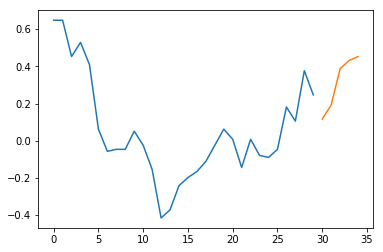

In [10]:
%matplotlib inline
plt.plot(range(len(x[0,:,0])), x[0,:,0])
plt.plot(range(len(x[0,:,0]), len(x[0,:,0])+len(y[0,:,0])), y[0,:,0])

In [5]:
test_x, test_y = generate_test_samples()
print(test_x.shape, test_y.shape)

(709, 30, 11) (709, 5, 1)


## Building the model - same multi-variate graph

In [11]:
from tensorflow.contrib import rnn
from tensorflow.python.ops import variable_scope
from tensorflow.python.framework import dtypes
import tensorflow as tf
import copy
import os

## Parameters
learning_rate = 0.01
lambda_l2_reg = 0.003  

## Network Parameters
# length of input signals
input_seq_len = input_seq_len
# length of output signals
output_seq_len = output_seq_len
# size of LSTM Cell
hidden_dim = 64 
# num of input signals
input_dim = X_train.shape[1]
# num of output signals
output_dim = y_train.shape[1]
# num of stacked lstm layers 
num_stacked_layers = 2 
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 2.5 

def build_graph(feed_previous = False):
    
    tf.reset_default_graph()
    
    global_step = tf.Variable(
                  initial_value=0,
                  name="global_step",
                  trainable=False,
                  collections=[tf.GraphKeys.GLOBAL_STEP, tf.GraphKeys.GLOBAL_VARIABLES])
    
    weights = {
        'out': tf.get_variable('Weights_out', \
                               shape = [hidden_dim, output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.truncated_normal_initializer()),
    }
    biases = {
        'out': tf.get_variable('Biases_out', \
                               shape = [output_dim], \
                               dtype = tf.float32, \
                               initializer = tf.constant_initializer(0.)),
    }
                                          
    with tf.variable_scope('Seq2seq'):
        # Encoder: inputs
        enc_inp = [
            tf.placeholder(tf.float32, shape=(None, input_dim), name="inp_{}".format(t))
               for t in range(input_seq_len)
        ]

        # Decoder: target outputs
        target_seq = [
            tf.placeholder(tf.float32, shape=(None, output_dim), name="y".format(t))
              for t in range(output_seq_len)
        ]

        # Give a "GO" token to the decoder. 
        # If dec_inp are fed into decoder as inputs, this is 'guided' training; otherwise only the 
        # first element will be fed as decoder input which is then 'un-guided'
        dec_inp = [ tf.zeros_like(target_seq[0], dtype=tf.float32, name="GO") ] + target_seq[:-1]

        with tf.variable_scope('LSTMCell'): 
            cells = []
            for i in range(num_stacked_layers):
                with tf.variable_scope('RNN_{}'.format(i)):
                    cells.append(tf.contrib.rnn.LSTMCell(hidden_dim))
            cell = tf.contrib.rnn.MultiRNNCell(cells)
         
        def _rnn_decoder(decoder_inputs,
                        initial_state,
                        cell,
                        loop_function=None,
                        scope=None):
          """RNN decoder for the sequence-to-sequence model.
          Args:
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            initial_state: 2D Tensor with shape [batch_size x cell.state_size].
            cell: rnn_cell.RNNCell defining the cell function and size.
            loop_function: If not None, this function will be applied to the i-th output
              in order to generate the i+1-st input, and decoder_inputs will be ignored,
              except for the first element ("GO" symbol). This can be used for decoding,
              but also for training to emulate http://arxiv.org/abs/1506.03099.
              Signature -- loop_function(prev, i) = next
                * prev is a 2D Tensor of shape [batch_size x output_size],
                * i is an integer, the step number (when advanced control is needed),
                * next is a 2D Tensor of shape [batch_size x input_size].
            scope: VariableScope for the created subgraph; defaults to "rnn_decoder".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing generated outputs.
              state: The state of each cell at the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
                (Note that in some cases, like basic RNN cell or GRU cell, outputs and
                 states can be the same. They are different for LSTM cells though.)
          """
          with variable_scope.variable_scope(scope or "rnn_decoder"):
            state = initial_state
            outputs = []
            prev = None
            for i, inp in enumerate(decoder_inputs):
              if loop_function is not None and prev is not None:
                with variable_scope.variable_scope("loop_function", reuse=True):
                  inp = loop_function(prev, i)
              if i > 0:
                variable_scope.get_variable_scope().reuse_variables()
              output, state = cell(inp, state)
              outputs.append(output)
              if loop_function is not None:
                prev = output
          return outputs, state

        def _basic_rnn_seq2seq(encoder_inputs,
                              decoder_inputs,
                              cell,
                              feed_previous,
                              dtype=dtypes.float32,
                              scope=None):
          """Basic RNN sequence-to-sequence model.
          This model first runs an RNN to encode encoder_inputs into a state vector,
          then runs decoder, initialized with the last encoder state, on decoder_inputs.
          Encoder and decoder use the same RNN cell type, but don't share parameters.
          Args:
            encoder_inputs: A list of 2D Tensors [batch_size x input_size].
            decoder_inputs: A list of 2D Tensors [batch_size x input_size].
            feed_previous: Boolean; if True, only the first of decoder_inputs will be
              used (the "GO" symbol), all other inputs will be generated by the previous 
              decoder output using _loop_function below. If False, decoder_inputs are used 
              as given (the standard decoder case).
            dtype: The dtype of the initial state of the RNN cell (default: tf.float32).
            scope: VariableScope for the created subgraph; default: "basic_rnn_seq2seq".
          Returns:
            A tuple of the form (outputs, state), where:
              outputs: A list of the same length as decoder_inputs of 2D Tensors with
                shape [batch_size x output_size] containing the generated outputs.
              state: The state of each decoder cell in the final time-step.
                It is a 2D Tensor of shape [batch_size x cell.state_size].
          """
          with variable_scope.variable_scope(scope or "basic_rnn_seq2seq"):
            enc_cell = copy.deepcopy(cell)
            _, enc_state = rnn.static_rnn(enc_cell, encoder_inputs, dtype=dtype)
            if feed_previous:
                return _rnn_decoder(decoder_inputs, enc_state, cell, _loop_function)
            else:
                return _rnn_decoder(decoder_inputs, enc_state, cell)

        def _loop_function(prev, _):
          '''Naive implementation of loop function for _rnn_decoder. Transform prev from 
          dimension [batch_size x hidden_dim] to [batch_size x output_dim], which will be
          used as decoder input of next time step '''
          return tf.matmul(prev, weights['out']) + biases['out']
        
        dec_outputs, dec_memory = _basic_rnn_seq2seq(
            enc_inp, 
            dec_inp, 
            cell, 
            feed_previous = feed_previous
        )

        reshaped_outputs = [tf.matmul(i, weights['out']) + biases['out'] for i in dec_outputs]
        
    # Training loss and optimizer
    with tf.variable_scope('Loss'):
        # L2 loss
        output_loss = 0
        for _y, _Y in zip(reshaped_outputs, target_seq):
            output_loss += tf.reduce_mean(tf.pow(_y - _Y, 2))

        # L2 regularization for weights and biases
        reg_loss = 0
        for tf_var in tf.trainable_variables():
            if 'Biases_' in tf_var.name or 'Weights_' in tf_var.name:
                reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))

        loss = output_loss + lambda_l2_reg * reg_loss

    with tf.variable_scope('Optimizer'):
        optimizer = tf.contrib.layers.optimize_loss(
                loss=loss,
                learning_rate=learning_rate,
                global_step=global_step,
                optimizer='Adam',
                clip_gradients=GRADIENT_CLIPPING)
        
    saver = tf.train.Saver
    
    return dict(
        enc_inp = enc_inp, 
        target_seq = target_seq, 
        train_op = optimizer, 
        loss=loss,
        saver = saver, 
        reshaped_outputs = reshaped_outputs,
        )

## Train the model 

In [12]:
total_iteractions = 100
batch_size = 16
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_pollution_case'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
11.5257
26.8208
31.756
4.70526
6.18088
8.22349
3.76478
1.75651
7.82475
1.84573
1.14613
2.79547
3.61245
2.69861
1.13865
0.907373
0.791358
1.26774
0.861136
1.12713
1.06782
1.30497
1.6152
2.02177
0.541613
0.661353
1.92352
1.6456
1.49546
0.914481
0.673717
0.787004
1.10607
0.431953
0.710768
0.735957
0.392711
0.749387
0.36318
0.515296
0.668095
1.39204
0.504841
0.731495
2.36337
0.384406
0.55854
0.404916
1.00044
0.352439
0.406724
0.800779
0.511212
0.289175
0.323337
0.324803
1.92942
0.821766
0.496132
0.657717
0.677956
0.851483
3.0798
3.11179
0.515262
0.531902
4.23728
0.571065
1.37093
0.56963
0.170705
0.170021
0.205952
1.75816
0.948972
0.677753
1.8095
0.778337
0.634663
0.241879
1.6232
0.65586
0.692685
0.445679
0.752967
2.68818
0.456118
0.193176
0.795069
0.174778
0.76054
0.262963
2.19425
0.255036
0.608561
0.966052
0.49301
0.487693
0.251533
0.459493
Checkpoint saved at:  ./multivariate_ts_pollution_case


## Inference on test 
Notice the batch prediction which is different to previous

In [13]:
rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess,  os.path.join('./', 'multivariate_ts_pollution_case'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_x[:, t, :] for t in range(input_seq_len)} # batch prediction
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([test_x.shape[0], output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = [np.expand_dims(pred, 1) for pred in final_preds]
    final_preds = np.concatenate(final_preds, axis = 1)
    print("Test mse is: ", np.mean((final_preds - test_y)**2))

INFO:tensorflow:Restoring parameters from ./multivariate_ts_pollution_case
Test mse is:  0.894930127718


In [14]:
## remove duplicate hours and concatenate into one long array
test_y_expand = np.concatenate([test_y[i].reshape(-1) for i in range(0, test_y.shape[0], 5)], axis = 0)
final_preds_expand = np.concatenate([final_preds[i].reshape(-1) for i in range(0, final_preds.shape[0], 5)], axis = 0)

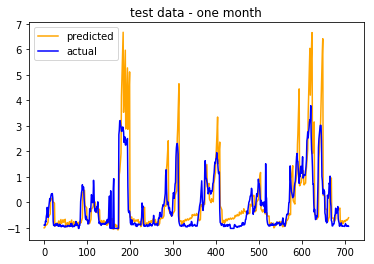

In [15]:
plt.plot(final_preds_expand, color = 'orange', label = 'predicted')
plt.plot(test_y_expand, color = 'blue', label = 'actual')
plt.title("test data - one month")
plt.legend(loc="upper left")
plt.show()